# 7506 - Organizacion de Datos - TP N°2

# Glove.6B.300

# 1. Librerias


In [1]:
#Paquetes Clasicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Paquetes para Preprocesamiento
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 

# Division de dataset
from sklearn.model_selection import train_test_split

#Vectorizadores
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


#Pipeline
from sklearn.pipeline import Pipeline

#Tuning de Parametros
from sklearn.model_selection import GridSearchCV

#TensorFlow
import tensorflow as tf
from tensorflow import keras

#Keras
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.utils import to_categorical
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Datos

In [2]:
#Dataset de entranamiento
df_train = pd.read_csv("train.csv")

In [3]:
#Dataset de test
df_test = pd.read_csv("test.csv")

## 2.1 Dataset 'train'

In [4]:
#Observo la constitucion general del Dataset de entrenamiento

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#Dimensiones del dataset

df_train.shape

(7613, 5)

In [6]:
#Cantidad de tweets catalogados como Verdaderos(1) y Falsos(0)

df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

**Tratamiento de NaN**

In [7]:
#Reemplazo los NaN por el string 'None' en las columnas 'location' y 'keyword'

df_train.location.fillna('None', inplace=True)
df_train.keyword.fillna('None', inplace=True)

In [8]:
#Observo como queda el dataframe

df_train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


**Tweets Repetidos**

In [9]:
duplicados_train = df_train['text'].duplicated(keep=False)
duplicados_train.sum()

179

In [10]:
dup_train = df_train[['text','target']][duplicados_train]
dup_train

,text,target
40,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...
7600,Evacuation order lifted for town of Roosevelt:...,1
7607,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


A simple vista se observa que alguno de los tweets repetidos tienen como target diferentes valores, lo cual en principio es confuso. Se decide eliminar todos los tweets repetidos

In [11]:
#Elimino las filas donde 'text' esta repetido

df_train = df_train.drop_duplicates('text',keep=False)

df_train.head()

,id,keyword,location,text,target
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,None,Forest fire near La Ronge Sask. Canada,1
2,5,None,None,All residents asked to 'shelter in place' are ...,1
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
#Verifico que el tamaño del dataset disminuyo la cantidad de repetidos

df_train.shape

(7434, 5)

## 2.2 Dataset 'test'

In [13]:
#Observo la constitucion general del Dataset de test

df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
#Dimensiones del dataset

df_test.shape

(3263, 4)

**Tratamiento de NaN**

In [15]:
#Reemplazo los NaN por el string 'None' en las columnas 'location' y 'keyword'

df_test.location.fillna('None', inplace=True)
df_test.keyword.fillna('None', inplace=True)

In [16]:
#Observo como queda el dataframe

df_test.head()

,id,keyword,location,text
0,0,None,None,Just happened a terrible car crash
1,2,None,None,"Heard about #earthquake is different cities, s..."
2,3,None,None,"there is a forest fire at spot pond, geese are..."
3,9,None,None,Apocalypse lighting. #Spokane #wildfires
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
duplicados_test = df_test['text'].duplicated(keep=False)
duplicados_test.sum()

39

In [18]:
dup_test = df_test[['text']][duplicados_test]
dup_test

,text
47,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
53,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
128,#AskConnor there's a zombie apocalypse. the it...
285,To fight bioterrorism sir.
286,To fight bioterrorism sir.
510,70 yrs since the atomic bombing of Hiroshima.....
540,.@denisleary Not sure how these folks rush int...
600,.@denisleary Not sure how these folks rush int...
607,Bushfire causes first victim in Albania :: Th...
612,Bushfire causes first victim in Albania :: Th...


En este caso no es necesario eliminar los tweets. Seria conveniente verificar que los mismos fueron catalogados de igual forma al finalizar el analisis

# 3. Preprocesamiento

Se definen funciones especificas para realizar el preprocesamiento de los datos:

In [19]:
# Transformar el texto a minuscula - OK

def minuscula(texto):
    return texto.lower()

In [20]:
#Remover URL - OK

def remover_url(texto):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', texto)

In [21]:
#Remover Usuarios (''@usuario') - OK
#Si aparecen usuarios combinados ('@usuario__usuario') queda '_usuario' y la funcion remover_no_alfabeto(texto) lo elimina

def remover_usuario(text):
    text = re.sub(r"\@[A-Za-z0-9]+", "", text)
    return text

In [22]:
# Remover Emoji - OK

def remover_emoji(texto):
    emoji_patrones = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF' 
        u'\U0001F680-\U0001F6FF' 
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_patrones.sub(r'', texto)

In [23]:
#Expandir las Abreviaturas - OK

abreviaturas = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def expandir_abreviatura(texto,mapping = abreviaturas):
    texto = ' '.join([mapping[t] if t in mapping else t for t in texto.split(" ")])
    return texto

In [24]:
#Expandir las Contracciones - OK

contracciones_mapeo = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", 
                       "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                       "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
                       "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                       "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", 
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", 
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def expandir_contraccion(texto,mapping = contracciones_mapeo):
    specials =["’", "‘", "´", "`"]
    for s in specials:
        texto = texto.replace(s,"'")
    
    texto = ' '.join([mapping[t] if t in mapping else t for t in texto.split(" ")])
    return texto

In [25]:
# Remover los tags HTML - OK

def remover_tag_html(texto):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', texto)

In [26]:
#Remover acentos - OK

def remover_acento(texto):
    import unicodedata
    texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return texto

In [27]:
#Remover Puntos - OK

def remover_punto(texto):
    import string
    texto = ''.join([c for c in texto if c not in string.punctuation])
    return texto

In [28]:
#Remover Numeros - OK

def remover_numero(texto):
    texto = ''.join([i for i in texto if not i.isdigit()])
    return texto

In [29]:
#Remover espacios en Blanco (extras/tabs) - OK

def remover_espacio_extra(texto):
    import re
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', texto).strip()

In [30]:
#Remueve todo lo que se sea del alfabeto - OK

def remover_no_alfabeto(texto):
    return ' '.join([i for i in texto.split() if i.isalpha() == True])

In [31]:
#Remover Stop-Word - OK

def remover_stop_word(texto):
    return " ".join ([word for word in word_tokenize(texto) if not word in stopwords.words('english')])

In [32]:
#Lematizar - OK

def lematizar(texto):
    lemma = WordNetLemmatizer()
    return " ".join([lemma.lemmatize(word) for word in word_tokenize(texto)])

Una vez definidias todas las funciones que se utilizaran para realizar la limpieza se define una funcion de ejecuta todas estas a una columna del dataset

In [33]:
def preprocesar_df(df, col_name, clean_col_name):
    df[clean_col_name] = df[col_name].apply(lambda x: minuscula (x))\
                                    .apply(lambda x: remover_url(x))\
                                    .apply(lambda x: remover_usuario(x))\
                                    .apply(lambda x: remover_emoji(x))\
                                    .apply(lambda x: expandir_abreviatura(x))\
                                    .apply(lambda x: expandir_contraccion(x))\
                                    .apply(lambda x: remover_tag_html(x))\
                                    .apply(lambda x: remover_acento(x))\
                                    .apply(lambda x: remover_punto(x))\
                                    .apply(lambda x: remover_numero(x))\
                                    .apply(lambda x: remover_espacio_extra(x))\
                                    .apply(lambda x: remover_no_alfabeto(x))\
                                    .apply(lambda x: remover_stop_word(x))\
                                    .apply(lambda x: lematizar(x))

## 3.1 Preprocesamiento del Dataset 'train' 

Realizo el preprocesamiento de la comlumna **'text'** del dataset **'train'**

In [34]:
#Llamo a la funcion que realiza el preprocesamiento

preprocesar_df(df_train,'text', 'texto_preprocesado')

In [35]:
#Observo las 5 primeras filas

df_train.head(30)

,id,keyword,location,text,target,texto_preprocesado
0,1,None,None,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,None,None,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,None,None,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,None,None,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,None,None,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...
5,8,None,None,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire update california hwy closed directi...
6,10,None,None,#flood #disaster Heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flooding...
7,13,None,None,I'm on top of the hill and I can see a fire in...,1,top hill see fire wood
8,14,None,None,There's an emergency evacuation happening now ...,1,emergency evacuation happening building across...
9,15,None,None,I'm afraid that the tornado is coming to our a...,1,afraid tornado coming area


In [36]:
#Dimensiones del dataset

df_train.shape

(7434, 6)

Defino los vectores que se utilizaran para el entrenamiento de los modelos

In [37]:
x_train = df_train['texto_preprocesado']

In [38]:
y_train = df_train['target']

## 3.2 Preprocesamiento del Dataset 'test' 

Realizo el preprocesamiento de la comlumna **'text'** del dataset **'test'**

In [39]:
preprocesar_df(df_test,'text', 'texto_preprocesado')

In [40]:
#Observo las 5 primeras filas

df_test.head()

,id,keyword,location,text,texto_preprocesado
0,0,None,None,Just happened a terrible car crash,happened terrible car crash
1,2,None,None,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,None,None,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,None,None,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,None,None,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [41]:
df_test.shape

(3263, 5)

Defino los vectores que se utilizaran para el entrenamiento de los modelos

In [42]:
x_test = df_test['texto_preprocesado']

# 4. Vectorizacion

In [43]:
#Divido el dataset de train en train y test

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [497]:
#Realizo la llamada al tokenizador

tokenizador_keras = Tokenizer(num_words=10000) #Defino un limite de 10000 en el numero de palabras a utilizar

In [498]:
#Fit del tokenizador en el texto de entrenamiento

tokenizador_keras.fit_on_texts(x_train)

In [499]:
#Aplico el tokenizador a los datos de entrenamiento

x_train_tokenizado = tokenizador_keras.texts_to_sequences(x_train)

#Observo un ejemplo

x_train_tokenizado[0:3]

[[98, 702, 1, 32, 4905, 273, 6, 4906],
 [1534, 42, 392, 786, 1726],
 [1251, 1041, 2530, 703, 1727, 83, 7, 4907, 4908, 43]]

In [500]:
#Aplico el tokenizador a los datos de validacion

x_val_tokenizado = tokenizador_keras.texts_to_sequences(x_val)

#Observo un ejemplo

x_val_tokenizado[0:3]

[[1503, 757, 45, 1697, 737, 322, 1379, 323],
 [442, 2242, 1649, 1424, 167, 85, 8865],
 [35, 1009, 1252, 3, 35, 471]]

In [501]:
#Aplico el tokenizador a los datos de test

x_test_tokenizado = tokenizador_keras.texts_to_sequences(x_test)

#Observo un ejemplo

x_test_tokenizado[0:3]

[[791, 1758, 43, 31],
 [332, 209, 937, 95, 389, 2005, 141],
 [115, 2, 697, 3448, 9300, 636, 393, 335]]

In [502]:
#Defino un tamaño del vocabulario contado la cantidad de palabras del tokenizador + 1

vocab_size = len(tokenizador_keras.word_index) + 1  # Adding 1 because of reserved 0 index

In [503]:
#Tamaño del vocabulario

vocab_size

11879

In [504]:
#Debido a que tengo secuencia de tokens de diferente largo es necesario "uniformizar" el largo
#Para cada sentencia completo con ceros donde sea necesario

from keras.preprocessing.sequence import pad_sequences

maxlen = 20

x_train_final = pad_sequences(x_train_tokenizado,padding='post', maxlen=maxlen)
x_val_final = pad_sequences(x_val_tokenizado,padding='post', maxlen=maxlen)
x_test_final = pad_sequences(x_test_tokenizado,padding='post', maxlen=maxlen)

print(x_train_final[2, :])

[1251 1041 2530  703 1727   83    7 4907 4908   43    0    0    0    0
    0    0    0    0    0    0]


 # 5. Plots 

In [505]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# 6. Glove glove.6B.300 - Pretrained Word Embedding

In [541]:
#Defino una funcion para crear la matriz de embeddings

def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open('3. Glove\glove.6B.300d.txt','r',encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [542]:
embedding_dim = 100
embedding_matrix = create_embedding_matrix(tokenizador_keras.word_index, embedding_dim)

In [543]:
embedding_matrix[1]

array([-1.34430006e-01, -1.63330007e-02,  9.10760015e-02, -1.35120004e-01,
        2.78519988e-01,  2.91779995e-01, -2.11260006e-01,  1.05740003e-01,
       -7.96800032e-02, -1.50670004e+00,  5.05150020e-01, -8.74740034e-02,
       -2.18189999e-01, -4.08440009e-02,  1.43120006e-01, -8.22170004e-02,
       -5.37970006e-01,  5.62300012e-02,  3.27089995e-01,  4.40369993e-01,
        2.84880012e-01,  4.77479994e-01,  6.24109983e-01,  1.80720001e-01,
       -3.89290005e-01, -7.32519999e-02, -5.95240016e-03, -3.54519993e-01,
        5.08419983e-02, -4.05710004e-02, -1.55479997e-01,  4.36789989e-01,
       -4.26299989e-01, -2.64869988e-01, -1.11000001e+00,  1.19870000e-01,
        1.97209995e-02,  1.46730006e-01, -1.22029997e-01,  3.15909982e-02,
        7.76769966e-02, -3.20789993e-01,  2.03930005e-01, -1.95570007e-01,
       -2.10290000e-01, -4.92909998e-02,  2.53549993e-01,  2.24329993e-01,
        1.04080001e-02,  8.95870030e-02,  3.60610008e-01, -5.32649994e-01,
        4.19459999e-01,  

In [544]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.7887027527569661

## 6.1 Modelo N°5

Layers:

    Embedding()
    Flatten()
    Dense()
    Dense()
    
Observacion: No se realiza regularizacion

In [308]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [309]:
#Creo un modelo secuencial
model_5 = Sequential()


#Agrero las layers

#Layer de embeddings
model_5.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

#Layer plana
model_5.add(layers.Flatten())

#Layer densa
model_5.add(layers.Dense(20, activation='relu'))

#Layer densa Final
model_5.add(layers.Dense(1, activation='sigmoid'))

#Compilo en Modelo
model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Observo un resumen del modelo
model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1187900   
_________________________________________________________________
flatten (Flatten)            (None, 2000)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40020     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,227,941
Trainable params: 40,041
Non-trainable params: 1,187,900
_________________________________________________________________


Epoch 1/3
199/199 - 1s - loss: 0.5303 - accuracy: 0.7464 - val_loss: 0.5082 - val_accuracy: 0.7492
Epoch 2/3
199/199 - 1s - loss: 0.4125 - accuracy: 0.8204 - val_loss: 0.5120 - val_accuracy: 0.7525
Epoch 3/3
199/199 - 1s - loss: 0.3590 - accuracy: 0.8498 - val_loss: 0.5314 - val_accuracy: 0.7485
Training Accuracy: 0.8831
Testing Accuracy:  0.7485


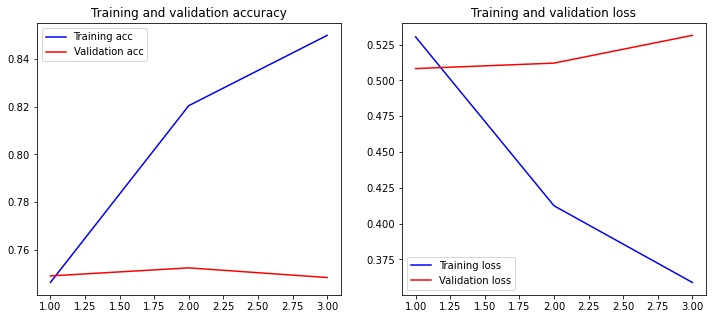

In [310]:
history_5 = model_5.fit(x_train_final, y_train,epochs=3,verbose=2,
                       validation_data=(x_val_final,y_val),
                       batch_size=30)

loss, accuracy = model_5.evaluate(x_train_final, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_5.evaluate(x_val_final, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_5)

In [1]:
prediccion_5 = model_5.predict(x_test_final)
prediccion_5_final = np.round(prediccion_5).astype(int).reshape(3263)
prediccion_5_final.sum()

NameError: name 'model_5' is not defined

Generacion del SUBMIT

Leo el archivo .csv modelo que tenemos se utilizar para realizar el submit a Kaggle

In [312]:
submission = pd.read_csv('sample_submission.csv')

Creo una nueva columna con los valores que predice el modelo

In [313]:
submission['target'] = prediccion_5_final

Guardo el archivo .csv para realizar el submit a Kaggle

In [314]:
submission.to_csv("glove_keras_red_neuronal5.csv", index=False)

## 6.2 Modelo N°6

Layers:

    Embedding()
    GlobalMaxPooling1D()
    Dense()
    Dense()

Observacion: No se realiza regularizacion

In [324]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [325]:
#Creo un modelo secuencial
model_6 = Sequential()


#Agrero las layers

#Layer de embeddings
model_6.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

#Layer de Pooling
model_6.add(layers.GlobalMaxPooling1D())

#Layer densa
model_6.add(layers.Dense(10, activation='relu'))

#Layer densa Final
model_6.add(layers.Dense(1, activation='sigmoid'))

#Compilo el modelo
model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Observo un resumen del modelo
model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1187900   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,188,921
Trainable params: 1,021
Non-trainable params: 1,187,900
_________________________________________________________________


Epoch 1/20
199/199 - 0s - loss: 0.6596 - accuracy: 0.6212 - val_loss: 0.6271 - val_accuracy: 0.6772
Epoch 2/20
199/199 - 0s - loss: 0.5923 - accuracy: 0.6973 - val_loss: 0.5786 - val_accuracy: 0.7088
Epoch 3/20
199/199 - 0s - loss: 0.5577 - accuracy: 0.7204 - val_loss: 0.5610 - val_accuracy: 0.7068
Epoch 4/20
199/199 - 0s - loss: 0.5403 - accuracy: 0.7342 - val_loss: 0.5551 - val_accuracy: 0.7122
Epoch 5/20
199/199 - 0s - loss: 0.5327 - accuracy: 0.7357 - val_loss: 0.5531 - val_accuracy: 0.7122
Epoch 6/20
199/199 - 0s - loss: 0.5248 - accuracy: 0.7439 - val_loss: 0.5553 - val_accuracy: 0.7102
Epoch 7/20
199/199 - 0s - loss: 0.5216 - accuracy: 0.7503 - val_loss: 0.5491 - val_accuracy: 0.7202
Epoch 8/20
199/199 - 0s - loss: 0.5180 - accuracy: 0.7545 - val_loss: 0.5490 - val_accuracy: 0.7189
Epoch 9/20
199/199 - 0s - loss: 0.5139 - accuracy: 0.7538 - val_loss: 0.5500 - val_accuracy: 0.7216
Epoch 10/20
199/199 - 0s - loss: 0.5109 - accuracy: 0.7600 - val_loss: 0.5562 - val_accuracy: 0.7128

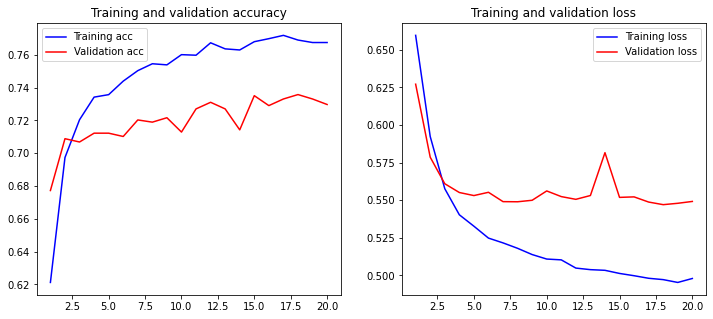

In [326]:
history_6 = model_6.fit(x_train_final, y_train,epochs=20,verbose=2,
                       validation_data=(x_val_final,y_val),
                       batch_size=30)

loss, accuracy = model_6.evaluate(x_train_final, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_6.evaluate(x_val_final, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_6)

In [327]:
prediccion_6 = model_6.predict(x_test_final)
prediccion_6_final = np.round(prediccion_6).astype(int).reshape(3263)
prediccion_6_final.sum()

1377

Generacion del SUBMIT

Leo el archivo .csv modelo que tenemos se utilizar para realizar el submit a Kaggle

In [328]:
submission = pd.read_csv('sample_submission.csv')

Creo una nueva columna con los valores que predice el modelo

In [329]:
submission['target'] = prediccion_6_final

Guardo el archivo .csv para realizar el submit a Kaggle

In [330]:
submission.to_csv("glove_keras_red_neuronal6.csv", index=False)

## 6.3 Modelo N°7 - Mejor Score (0.80539)

Layers:
    
    Embedding()
    SpatialDropout1D() 
    LSTM()
    Dense()
 
 
Observacion: Se realiza regularizacion con el layer SpatialDropout1D()

In [359]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [360]:
#Creo un modelo secuencial
model_7 = Sequential()


#Agrero las layers

#Layer de embeddings
model_7.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

#Layer Dropout
model_7.add(SpatialDropout1D(0.2))

#Layer LSTM
model_7.add(LSTM(64, dropout=0.20, recurrent_dropout=0.20))

#Layer densa Final
model_7.add(layers.Dense(1, activation='sigmoid'))

#Compilo el modelo
model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Observo un resumen del modelo
model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1187900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,230,205
Trainable params: 42,305
Non-trainable params: 1,187,900
_________________________________________________________________


Epoch 1/10
199/199 - 6s - loss: 0.5394 - accuracy: 0.7404 - val_loss: 0.4961 - val_accuracy: 0.7666
Epoch 2/10
199/199 - 5s - loss: 0.4963 - accuracy: 0.7691 - val_loss: 0.4914 - val_accuracy: 0.7761
Epoch 3/10
199/199 - 6s - loss: 0.4792 - accuracy: 0.7811 - val_loss: 0.4777 - val_accuracy: 0.7781
Epoch 4/10
199/199 - 5s - loss: 0.4677 - accuracy: 0.7885 - val_loss: 0.4678 - val_accuracy: 0.7781
Epoch 5/10
199/199 - 6s - loss: 0.4510 - accuracy: 0.7940 - val_loss: 0.4703 - val_accuracy: 0.7841
Epoch 6/10
199/199 - 7s - loss: 0.4580 - accuracy: 0.7927 - val_loss: 0.4570 - val_accuracy: 0.7882
Epoch 7/10
199/199 - 6s - loss: 0.4343 - accuracy: 0.8091 - val_loss: 0.4536 - val_accuracy: 0.7909
Epoch 8/10
199/199 - 5s - loss: 0.4259 - accuracy: 0.8152 - val_loss: 0.4688 - val_accuracy: 0.7882
Epoch 9/10
199/199 - 5s - loss: 0.4144 - accuracy: 0.8147 - val_loss: 0.4600 - val_accuracy: 0.7909
Epoch 10/10
199/199 - 5s - loss: 0.4136 - accuracy: 0.8157 - val_loss: 0.4514 - val_accuracy: 0.8009

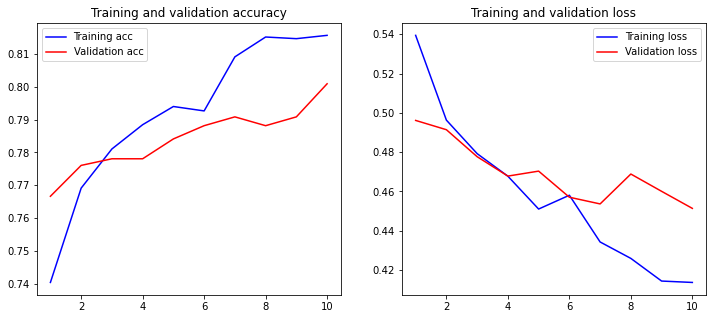

In [361]:
history_7 = model_7.fit(x_train_final, y_train,epochs=10,verbose=2,
                       validation_data=(x_val_final,y_val),
                       batch_size=30)

loss, accuracy = model_7.evaluate(x_train_final, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_7.evaluate(x_val_final, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_7)

In [362]:
prediccion_7 = model_7.predict(x_test_final)
prediccion_7_final = np.round(prediccion_7).astype(int).reshape(3263)
prediccion_7_final.sum()

1223

Generacion del SUBMIT

Leo el archivo .csv modelo que tenemos se utilizar para realizar el submit a Kaggle

In [363]:
submission = pd.read_csv('sample_submission.csv')

Creo una nueva columna con los valores que predice el modelo

In [364]:
submission['target'] = prediccion_7_final

Guardo el archivo .csv para realizar el submit a Kaggle

In [365]:
submission.to_csv("glove_keras_red_neuronal7.csv", index=False)

## 6.4 Modelo N°8

Layers:
    
    Embedding()
    SpatialDropout1D() 
    LSTM()
    Dense()
 
 
Observacion: Se realiza regularizacion con el layer SpatialDropout1D()

In [613]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [614]:
#Creo un modelo secuencial
model_8 = Sequential()


#Agrero las layers

#Layer de embeddings
model_8.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

#Layer Dropout
model_8.add(SpatialDropout1D(0.2))

#Layer LSTM
model_8.add(LSTM(64, dropout=0.10,recurrent_dropout=0.10))

#Layer densa
model_8.add(layers.Dense(64, activation='sigmoid'))

#Layer densa Final
model_8.add(layers.Dense(1, activation='sigmoid'))

#Compilo el modelo
model_8.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Observo un resumen del modelo
model_8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1187900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,234,365
Trainable params: 46,465
Non-trainable params: 1,187,900
_________________________________________________________________


Epoch 1/14
199/199 - 8s - loss: 0.5413 - accuracy: 0.7316 - val_loss: 0.4959 - val_accuracy: 0.7640
Epoch 2/14
199/199 - 6s - loss: 0.4858 - accuracy: 0.7765 - val_loss: 0.4886 - val_accuracy: 0.7814
Epoch 3/14
199/199 - 6s - loss: 0.4705 - accuracy: 0.7851 - val_loss: 0.4744 - val_accuracy: 0.7821
Epoch 4/14
199/199 - 6s - loss: 0.4585 - accuracy: 0.7893 - val_loss: 0.4726 - val_accuracy: 0.7787
Epoch 5/14
199/199 - 6s - loss: 0.4462 - accuracy: 0.7967 - val_loss: 0.4760 - val_accuracy: 0.7835
Epoch 6/14
199/199 - 6s - loss: 0.4378 - accuracy: 0.8073 - val_loss: 0.4591 - val_accuracy: 0.7868
Epoch 7/14
199/199 - 6s - loss: 0.4234 - accuracy: 0.8169 - val_loss: 0.4620 - val_accuracy: 0.7861
Epoch 8/14
199/199 - 6s - loss: 0.4119 - accuracy: 0.8209 - val_loss: 0.4803 - val_accuracy: 0.7801
Epoch 9/14
199/199 - 6s - loss: 0.4010 - accuracy: 0.8275 - val_loss: 0.4636 - val_accuracy: 0.7949
Epoch 10/14
199/199 - 6s - loss: 0.3946 - accuracy: 0.8241 - val_loss: 0.4635 - val_accuracy: 0.7902

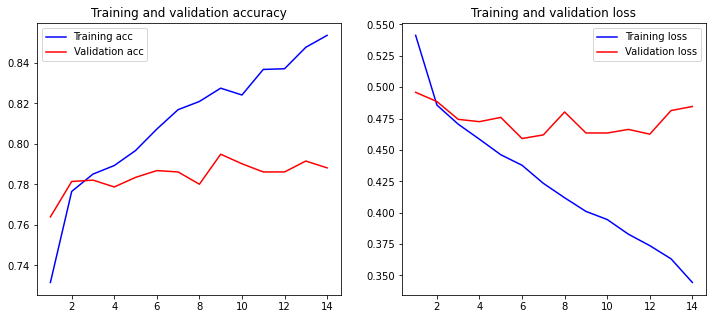

In [615]:
history_8 = model_8.fit(x_train_final, y_train,epochs=14,verbose=2,
                       validation_data=(x_val_final,y_val),
                       batch_size=30)

loss, accuracy = model_8.evaluate(x_train_final, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_8.evaluate(x_val_final, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_8)

In [604]:
prediccion_8 = model_8.predict(x_test_final)
prediccion_8_final = np.round(prediccion_8).astype(int).reshape(3263)
prediccion_8_final.sum()

953

Generacion del SUBMIT

Leo el archivo .csv modelo que tenemos se utilizar para realizar el submit a Kaggle

In [566]:
submission = pd.read_csv('sample_submission.csv')

Creo una nueva columna con los valores que predice el modelo

In [567]:
submission['target'] = prediccion_8_final

Guardo el archivo .csv para realizar el submit a Kaggle

In [568]:
submission.to_csv("glove_keras_red_neuronal8.csv", index=False)

## 6.5 Modelo N°9

In [620]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [621]:
#Creo un modelo secuencial
model_9 = Sequential()

#Agrero las layers

#Layer de embeddings
model_9.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

#Layer Dropout
model_9.add(SpatialDropout1D(0.2))

#Layer LSTM
model_9.add(layers.LSTM(64,return_sequences=True))

#Layer LSTM
model_9.add(layers.LSTM(32))

#Layer Densa
model_9.add(layers.Dense(64,activation='relu'))

#Layer densa Final
model_9.add(layers.Dense(1, activation='sigmoid'))

#Compilo el modelo
model_9.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Observo un resumen del modelo
model_9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           1187900   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 20, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 64)            42240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,244,733
Trainable params: 56,833
Non-trainable params: 1,187,900
_________________________________________

Epoch 1/6
1190/1190 - 32s - loss: 0.5192 - accuracy: 0.7616 - val_loss: 0.4946 - val_accuracy: 0.7727
Epoch 2/6
1190/1190 - 31s - loss: 0.4747 - accuracy: 0.7928 - val_loss: 0.4814 - val_accuracy: 0.7835
Epoch 3/6
1190/1190 - 31s - loss: 0.4610 - accuracy: 0.7962 - val_loss: 0.4751 - val_accuracy: 0.7848
Epoch 4/6
1190/1190 - 31s - loss: 0.4276 - accuracy: 0.8130 - val_loss: 0.4602 - val_accuracy: 0.7956
Epoch 5/6
1190/1190 - 29s - loss: 0.4193 - accuracy: 0.8191 - val_loss: 0.4608 - val_accuracy: 0.7935
Epoch 6/6
1190/1190 - 29s - loss: 0.4018 - accuracy: 0.8292 - val_loss: 0.4521 - val_accuracy: 0.8030
Training Accuracy: 0.8641
Testing Accuracy:  0.8030


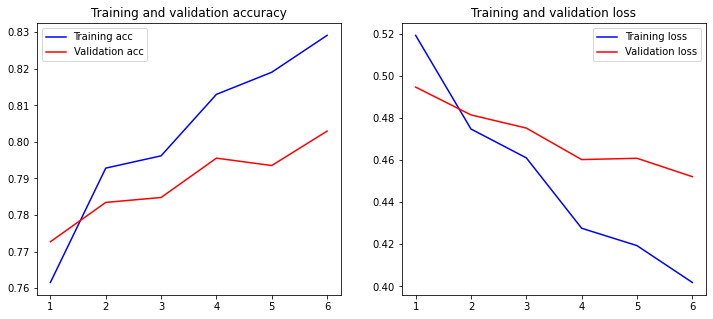

In [622]:
history_9 = model_9.fit(x_train_final, y_train,epochs=6,verbose=2,
                       validation_data=(x_val_final,y_val),
                       batch_size=5)

loss, accuracy = model_9.evaluate(x_train_final, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model_9.evaluate(x_val_final, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_9)

In [623]:
prediccion_9 = model_9.predict(x_test_final)
prediccion_9_final = np.round(prediccion_9).astype(int).reshape(3263)
prediccion_9_final.sum()

1134

Generacion del SUBMIT

Leo el archivo .csv modelo que tenemos se utilizar para realizar el submit a Kaggle

In [624]:
submission = pd.read_csv('sample_submission.csv')

Creo una nueva columna con los valores que predice el modelo

In [625]:
submission['target'] = prediccion_9_final

Guardo el archivo .csv para realizar el submit a Kaggle

In [626]:
submission.to_csv("glove_keras_red_neuronal9.csv", index=False)